In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.distributions import Normal 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
random.seed(0)
torch.cuda.manual_seed_all(999)

In [2]:
# 데이터 전처리

df = pd.read_csv('SJ001_merge_1day_full.csv')

# Outlier mean값으로 대체
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

solar_max = data.max(axis=0)[2]
capacity_value = 500

# 월별 평균치 계산 (한달을 31일로 가정)
g_avg = np.zeros((12, 97))

for i in range(12):
    group = df[(df.DATE >= 0+30*i) & (df.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values


date = data[:,0]
time = data[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df['avg'] = g_avg[d,t]

#평균치를 데이터에 포함시켜서 0~1사이로 scaling
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

maxi = data.max(axis=0)
mini = data.min(axis=0)
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [3]:
# Training 데이터 생성 (데이터는 [에너지, 날짜, 시간, 예보5개, 월별 평균량] 으로 구성)
train_day = 497
test_day = 29

interval = 97
# input_size = 8
input_size = 9

train_num = 97* (train_day-1) + 1
test_num = 97* (test_day-1) + 1

input_series = np.zeros((train_num + test_num, interval, input_size))
target_series = np.zeros((train_num + test_num, interval, input_size))

for i in range(train_num + test_num):
    if i < train_num:
        input_series[i, :, 0] = data[i: i+interval, 2]
        input_series[i, :, 1:3] = data[i: i+interval, 0:2]
    #     input_series[i, :, 3:8] = data[i: i+interval, -6:-1]
        input_series[i, :, 3:9] = data[i: i+interval, -6:]

        target_series[i, :, 0] = data[i+interval: i+interval*2, 2]
        target_series[i, :, 1:3] = data[i+interval: i+interval*2, 0:2]
    #     target_series[i, :, 3:8] = data[i+interval: i+interval*2, -6:-1]
        target_series[i, :, 3:9] = data[i+interval: i+interval*2, -6:]
    else:
        input_series[i, :, 0] = data[i+interval-1: i+interval*2-1, 2]
        input_series[i, :, 1:3] = data[i+interval-1: i+interval*2-1, 0:2]
        input_series[i, :, 3:9] = data[i+interval-1: i+interval*2-1, -6:]

        target_series[i, :, 0] = data[i+interval*2-1: i+interval*3-1, 2]
        target_series[i, :, 1:3] = data[i+interval*2-1: i+interval*3-1, 0:2]
        target_series[i, :, 3:9] = data[i+interval*2-1: i+interval*3-1, -6:]        

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        batch_size, seq_len = input.shape[0], input.shape[1]
        output = input.float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [5]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(AttnDecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.dim_ch1 = nn.Linear(self.input_size, self.hidden_size)
        self.dim_ch2 = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.attn = nn.Linear(self.hidden_size * 2, interval)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size + self.input_size, interval)
#         self.attn_combine = nn.Linear(self.hidden_size + self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output):
        batch_size = input.shape[0]
        input = input.view(batch_size, 1, self.input_size).float()
        hidden = hidden.float()
        hidd_att = hidden.view(batch_size, 1, self.hidden_size)
        embedded = F.relu(self.dim_ch1(input))
        embedded = F.relu(self.dim_ch2(embedded))

        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidd_att), 2)), dim = 2)
        attn_applied = torch.bmm(attn_weights, encoder_output)

        output = torch.cat((embedded, attn_applied), 2)
        output = self.attn_combine(output)
        output = F.relu(output)
        
#         attn_weights = F.softmax(self.attn(torch.cat((input, hidd_att), 2)), dim = 2)
#         attn_applied = torch.bmm(attn_weights, encoder_output)

#         output = torch.cat((input, attn_applied), 2)
#         output = self.attn_combine(output)
#         output = F.relu(output)

        output, hidden = self.gru(output, hidden)
        output = F.relu(self.out(output))
        
        return output, hidden, attn_weights

In [6]:
def log_prob(mean, std, target):
    pdf = torch.exp(-(target - mean)**2 / (2*std**2))/std/math.sqrt(2*math.pi)
    return torch.log(pdf + 1e-5)

In [7]:
hidden_size = 32
encoder1 = EncoderRNN(input_size, hidden_size).to(device)
decoder1 = AttnDecoderRNN(input_size, hidden_size, 2).to(device)

In [8]:
teacher_forcing_ratio = 0.5
max_grad_norm = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer):
    
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size = batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
#     encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = input_tensor[:, -1:, :]
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    outputs = []
    loss = torch.zeros(1).to(device).double()
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
#             outputs.append(decoder_output.squeeze(0))
            decoder_input = target_tensor[:, di:di+1, :] # Teacher forcing
            nll = -log_prob(decoder_output[:,:,0:1].double(), decoder_output[:,:,1:2].double()+1e-5, target_tensor[:, di:di+1, 0:1].double())
            loss += torch.sum(nll) / batch_size
#             loss += torch.max(nll)

    else:
        # Without teacher forcing: use its own predictions as the next input 
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            decoder_sample = Normal(decoder_output[:,:,0:1], decoder_output[:,:,1:2]/20).sample()
            decoder_input = torch.cat([decoder_sample[:,:,0:1], target_tensor[:, di:di+1, 1:].float()], dim=2)
            nll = -log_prob(decoder_sample[:,:,0:1].double(), decoder_output[:,:,1:2].double()+1e-5, target_tensor[:, di:di+1, 0:1].double())
#             decoder_input = torch.cat([decoder_output[:,:,0:1], target_tensor[:, di:di+1, 1:].float()], dim=2)
#             nll = -log_prob(decoder_output[:,:,0:1].double(), decoder_output[:,:,1:2].double()+1e-5, target_tensor[:, di:di+1, 0:1].double())
            loss += torch.sum(nll) / batch_size
#             loss += torch.max(nll)
            
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_grad_norm)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_grad_norm)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [9]:
def trainIters(encoder, decoder, batch_size = 50, epoch = 100, n_iters=train_num, print_every=1000, plot_every=100, learning_rate=0.001):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()
    
    for ep in range(epoch):
        loss = 0
        
        for b in range(int(train_num / batch_size)):
            input_tensor = input_series[batch_size*b:batch_size*(b+1)]
            target_tensor = target_series[batch_size*b:batch_size*(b+1)]

            loss += train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer)
        loss = loss/ int(train_num / batch_size)    
        plot_losses.append(loss)
        print("Epoch ", ep+1, ", NLL: ", loss)
    plt.plot(plot_losses)

Epoch  1 , NLL:  -1.6647149798651093
Epoch  2 , NLL:  -2.3577283106891715
Epoch  3 , NLL:  -2.4662593368928243
Epoch  4 , NLL:  -2.748279908434437
Epoch  5 , NLL:  -2.5425127679058757
Epoch  6 , NLL:  -2.510547236055282
Epoch  7 , NLL:  -2.6651521502123603
Epoch  8 , NLL:  -2.5805114036874817
Epoch  9 , NLL:  -2.493763806015544
Epoch  10 , NLL:  -2.7289324559161248
Epoch  11 , NLL:  -2.6985566640116505
Epoch  12 , NLL:  -2.7506388757465055
Epoch  13 , NLL:  -2.5236726121690083
Epoch  14 , NLL:  -2.512115187444693
Epoch  15 , NLL:  -2.520786647699031
Epoch  16 , NLL:  -2.679689025749469
Epoch  17 , NLL:  -2.553754365569618
Epoch  18 , NLL:  -2.7453532854886094
Epoch  19 , NLL:  -2.872240949600987
Epoch  20 , NLL:  -2.7506734404278275
Epoch  21 , NLL:  -2.8123567228347577
Epoch  22 , NLL:  -2.813389040911314
Epoch  23 , NLL:  -2.6338023851782557
Epoch  24 , NLL:  -2.737257295271988
Epoch  25 , NLL:  -2.676015495701874
Epoch  26 , NLL:  -2.45957325720764
Epoch  27 , NLL:  -2.7921903947941

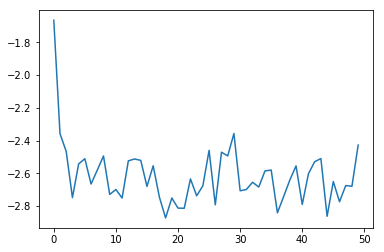

In [10]:
trainIters(encoder1, decoder1, epoch=50)

In [11]:
def evaluate(encoder, decoder, input_tensor, target_tensor, target_length):
    with torch.no_grad():
        input_tensor = input_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size = 1)

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = input_tensor[:, -1:, :] 
        decoder_hidden = encoder_hidden
        
        decoded = []
        std = []
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_output)
            decoded.append(decoder_output[:,:,0:1].item())
            std.append(decoder_output[:,:,1:2].item())
            decoder_input = torch.cat([decoder_output[:,:,0:1], target_tensor[:, di:di+1, 1:].float()], dim=2)
            
        return np.array(decoded), np.array(std)

In [31]:
# torch.save(encoder1, 'encoder1_conf_24h')
# torch.save(decoder1, 'decoder1_conf_24h')

/home/cwj/venv/local/lib/python3.5/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/cwj/venv/local/lib/python3.5/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# encoder1 = torch.load('encoder1_conf_24h')
# decoder1 = torch.load('decoder1_conf_24h')

In [12]:
predicted = torch.zeros(test_day * interval).to(device)
for i in range(test_day):
    dec,_ = evaluate(encoder1, decoder1, X_test[interval*i], y_test[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)


loss = nn.MSELoss()
whole_data = torch.from_numpy(data[-interval*test_day:,2]).to(device).float()
# train_loss = loss(predicted[:interval*train_day], whole_data[:interval*train_day])
test_loss = loss(predicted, whole_data)
NRMSE = torch.sqrt(test_loss) / whole_data.max()
NMAE = torch.abs(predicted-whole_data)
NMAE = torch.sum(NMAE) * 100 * solar_max / len(predicted) / capacity_value
print("hidden_node : %d" %(hidden_size))
# print("train_loss : %f" %(train_loss))
print("test_loss : %f" %(test_loss))
print("NRMSE : %f" %(NRMSE))
print("NMAE : %f" %(NMAE))

hidden_node : 32
test_loss : 0.038219
NRMSE : 0.204450
NMAE : 11.154961


In [24]:
df2 = pd.read_csv('SJ002_merge_1day_full.csv')
data2 = df2.iloc[:, 1:].values
for i in range(len(data2)):
    if data2[i, 2] > 500:
        data2[i, 2] = (data2[i-1, 2] + data2[i+1, 2])/2 

g_avg = np.zeros((12, 97))

for i in range(12):
    group = df2[(df2.DATE >= 0+30*i) & (df2.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values

date = data2[:,0]
time = data2[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df2['avg'] = g_avg[d,t]
ind = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data2 = df2.iloc[:, ind].values
for i in range(len(data2)):
    if data2[i, 2] > 500:
        data2[i, 2] = (data2[i-1, 2] + data2[i+1, 2])/2 
data2 = (data2 - mini) / (maxi - mini)

In [25]:
# 각 월별 1일이 1월1일부터 몇번째 날인가 계산
month = np.zeros(13)
from datetime import date
for i in range(12):
    month[i] = (date(2018, i+1, 1) - date(2017, 12, 31)).days
month[12] = 366
month = month.astype('int')

# month_index => 첫번째 값 = 29 means 타겟데이터의 29일치가 1월달 데이터
k = df2.values[:,1]
month_index = np.zeros(13)
m = 1
for i in range(len(df2)-interval):
    if (int(k[i+interval-1]) < month[m]) and (int(k[i+interval]) >= month[m]):
        month_index[m] = i/97
        m += 1
    else:
        pass
month_index[0] = 0
month_index[-1]=336
month_index = month_index.astype('int')

test_day = 336
test_num = 97* test_day
s2_input_series = np.zeros((test_num, interval, input_size))
s2_target_series = np.zeros((test_num, interval, input_size))

for i in range(test_num):
    s2_input_series[i, :, 0] = data2[i: i+interval, 2]
    s2_input_series[i, :, 1:3] = data2[i: i+interval, 0:2]
    s2_input_series[i, :, 3:9] = data2[i: i+interval, -6:]
    
    s2_target_series[i, :, 0] = data2[i+interval: i+interval*2, 2]
    s2_target_series[i, :, 1:3] = data2[i+interval: i+interval*2, 0:2]
    s2_target_series[i, :, 3:9] = data2[i+interval: i+interval*2, -6:]
    
s2_input_series = torch.from_numpy(s2_input_series).to(device)
s2_target_series = torch.from_numpy(s2_target_series).to(device)

In [30]:
# epoch = 50
predicted = torch.zeros(interval * test_day).to(device)
predicted_std = torch.zeros(interval * test_day).to(device)
for i in range(test_day):
    dec,std = evaluate(encoder1, decoder1, s2_input_series[interval*i], s2_target_series[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)
    predicted_std[interval*i: interval*(i+1)] = torch.Tensor(std)

loss = nn.MSELoss()
whole_data = torch.from_numpy(data2[interval:interval + interval* test_day,2]).to(device).float()
test_loss = loss(predicted, whole_data)
NRMSE = torch.sqrt(test_loss) / whole_data.max()
NMAE = torch.sum(torch.abs(predicted-whole_data)) * 100 * solar_max / len(predicted) / capacity_value
print("NRMSE : %f" %(NRMSE))
print("NMAE : %f" %(NMAE))

NRMSE : 0.116784
NMAE : 6.880300


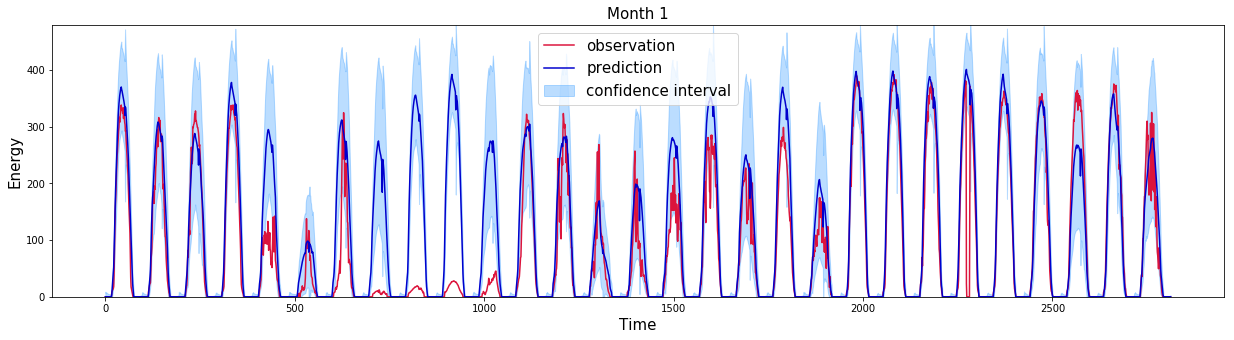

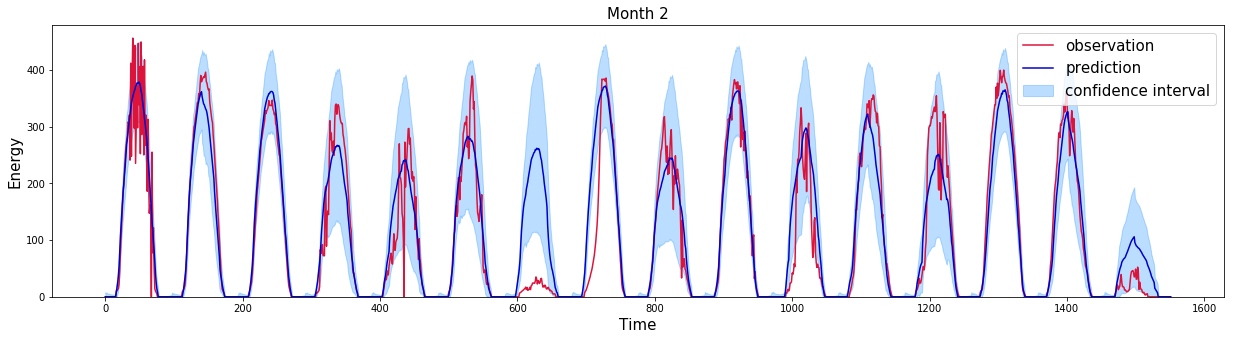

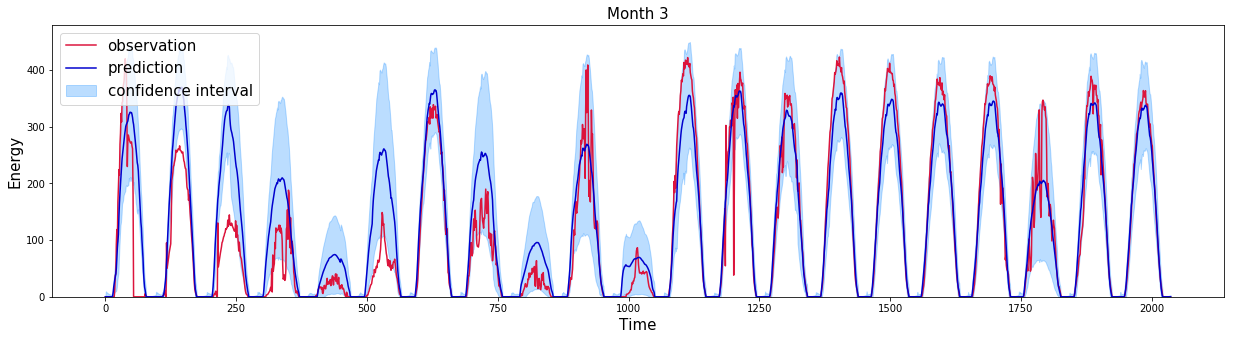

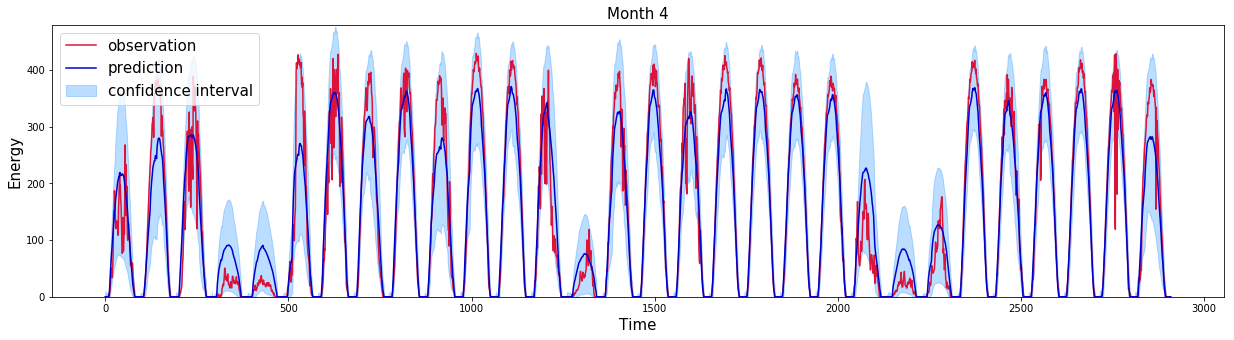

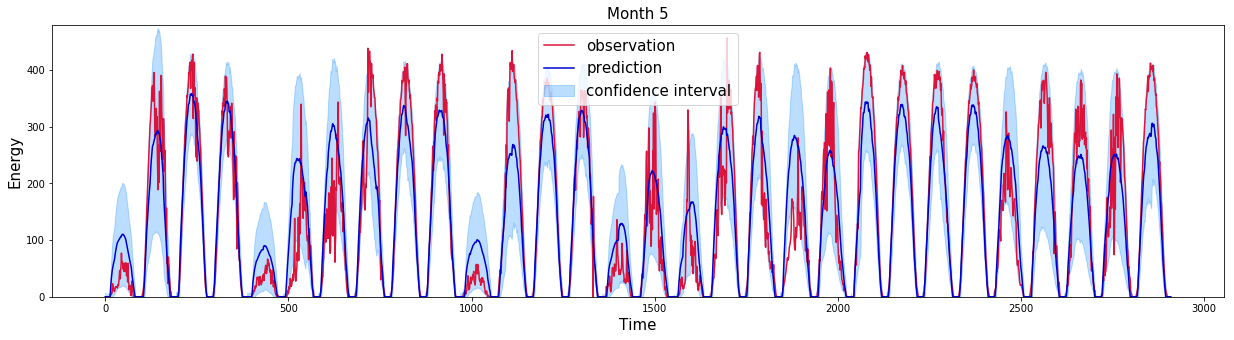

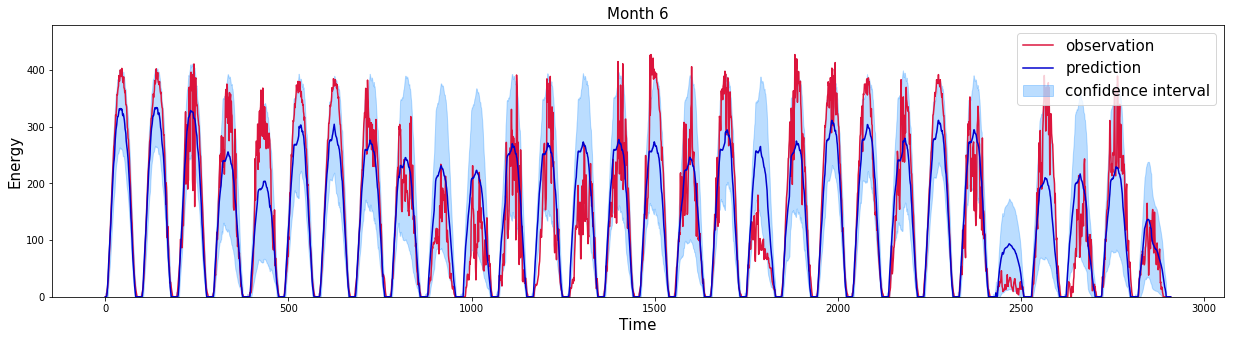

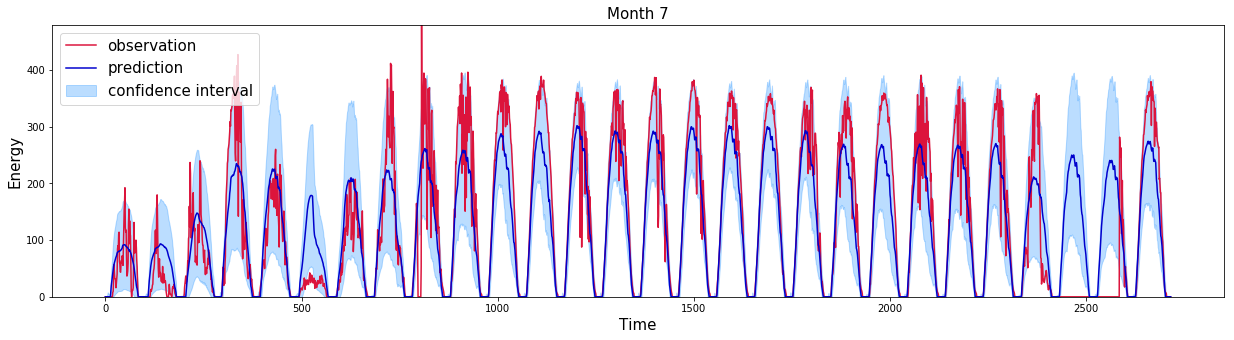

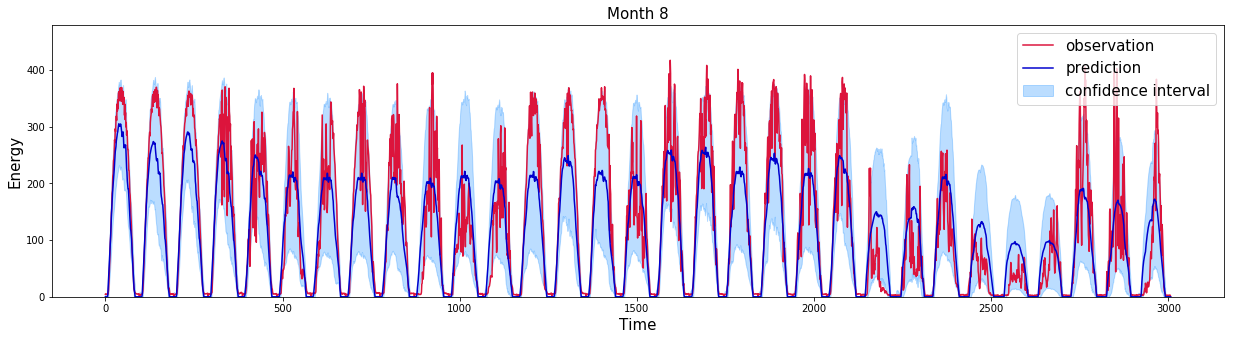

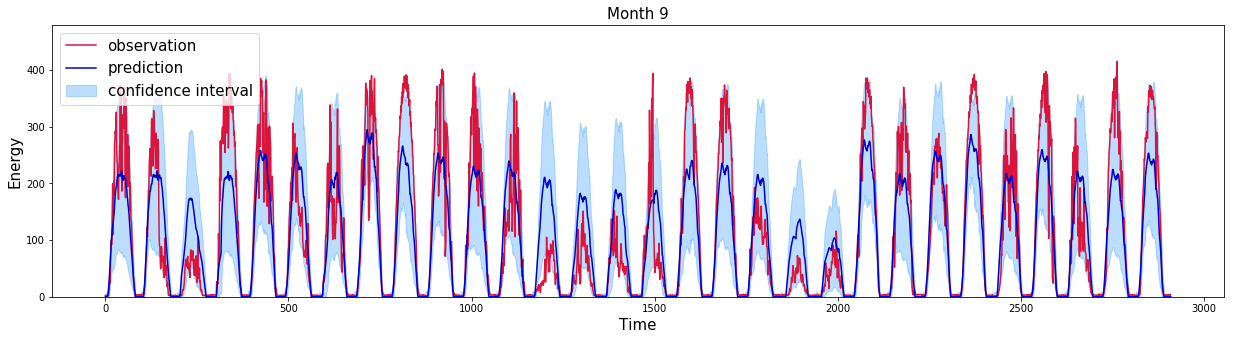

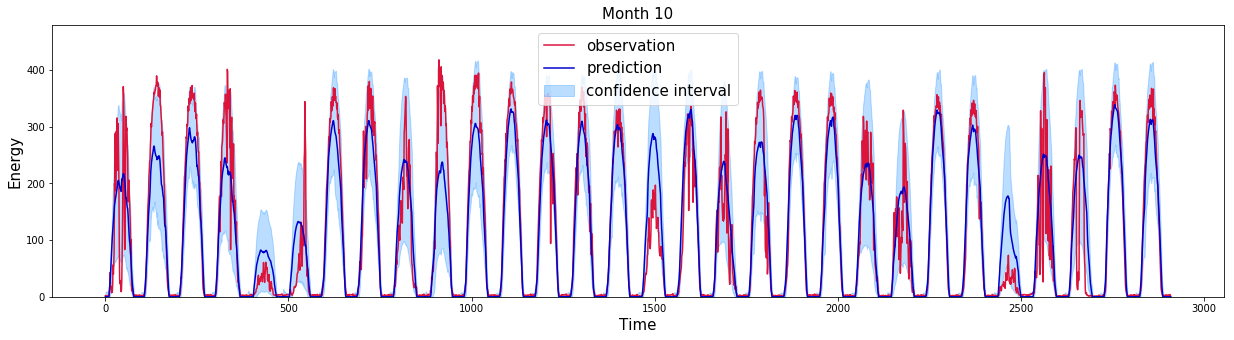

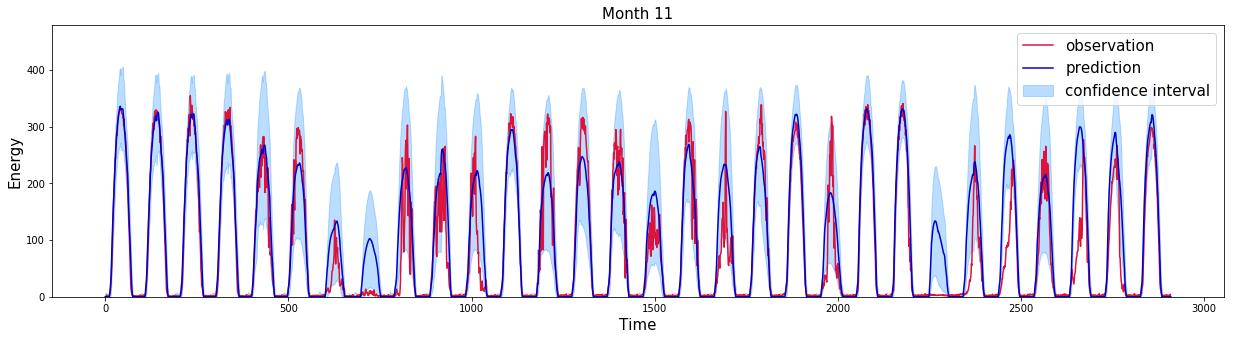

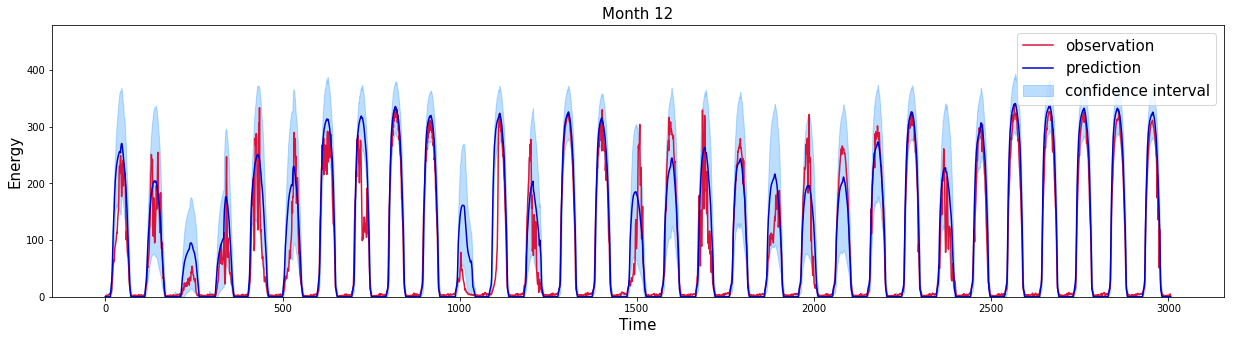

In [39]:
# epoch = 50
month_index = month_index.astype('int')
for i in range(12):
    plt.figure(figsize = (21,5))
    plt.plot(whole_data[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, label = 'observation', color = 'crimson')
    plt.plot(predicted[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, label = 'prediction', color = 'mediumblue')
    plt.fill_between(np.arange(interval*(month_index[i+1]-month_index[i])), predicted[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max +1.96*predicted_std[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, predicted[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max -1.96*predicted_std[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, label='confidence interval', color = 'dodgerblue', alpha=0.3 )
    plt.title('Month %d' %(i+1), fontsize = 15)
    plt.ylabel('Energy', fontsize = 15)
    plt.xlabel('Time', fontsize = 15)
    plt.ylim([0,solar_max])
    plt.legend(fontsize=15)

In [40]:
# epoch = 50
month_index = month_index.astype('int')
for i in range(12):
    test_loss = loss(predicted[month_index[i]*interval: month_index[i+1]*interval], whole_data[month_index[i]*interval: month_index[i+1]*interval])
    NRMSE = torch.sqrt(test_loss) / whole_data[month_index[i]*interval: month_index[i+1]*interval].max()
    NMAE = torch.sum(torch.abs(predicted[month_index[i]*interval: month_index[i+1]*interval]-whole_data[month_index[i]*interval: month_index[i+1]*interval])) * 100 * solar_max / len(predicted[month_index[i]*interval: month_index[i+1]*interval]) / capacity_value
    print("Month %d NRMSE: %f" %(i+1, NRMSE))
    print("Month %d NMAE: %f" %(i+1, NMAE))

Month 1 NRMSE: 0.198825
Month 1 NMAE: 7.664698
Month 2 NRMSE: 0.112935
Month 2 NMAE: 5.586162
Month 3 NRMSE: 0.130250
Month 3 NMAE: 6.493966
Month 4 NRMSE: 0.095038
Month 4 NMAE: 5.405990
Month 5 NRMSE: 0.123616
Month 5 NMAE: 7.853901
Month 6 NRMSE: 0.134834
Month 6 NMAE: 8.122942
Month 7 NRMSE: 0.140484
Month 7 NMAE: 8.831196
Month 8 NRMSE: 0.141430
Month 8 NMAE: 8.178471
Month 9 NRMSE: 0.147784
Month 9 NMAE: 8.422497
Month 10 NRMSE: 0.115467
Month 10 NMAE: 5.939461
Month 11 NRMSE: 0.128434
Month 11 NMAE: 5.047072
Month 12 NRMSE: 0.121083
Month 12 NMAE: 4.490023


0


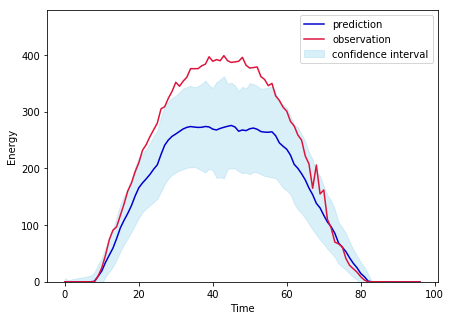

1


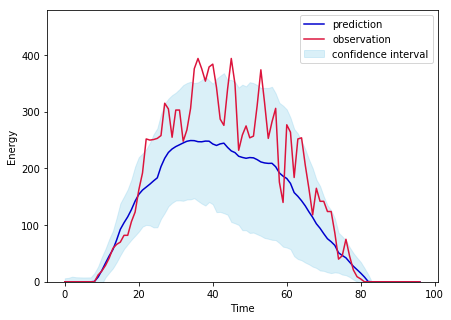

2


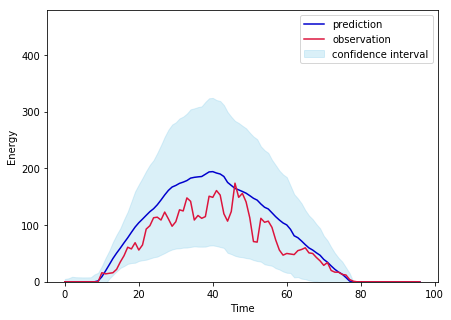

3


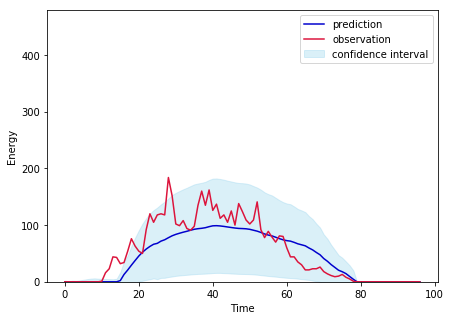

4


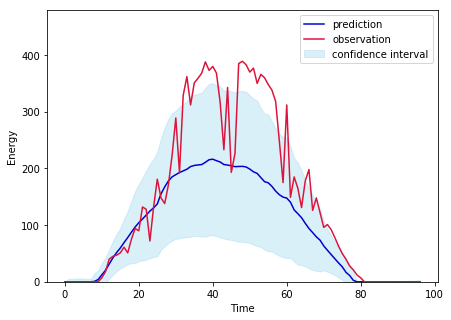

5


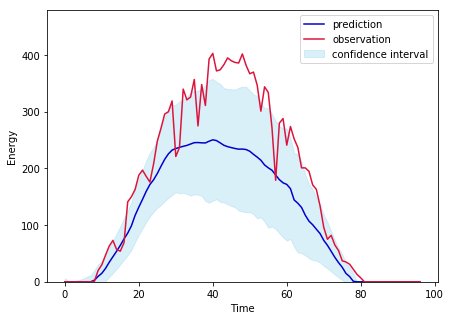

6


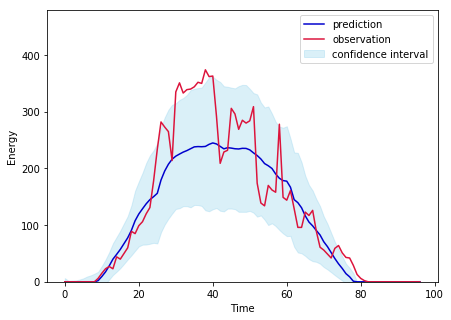

7


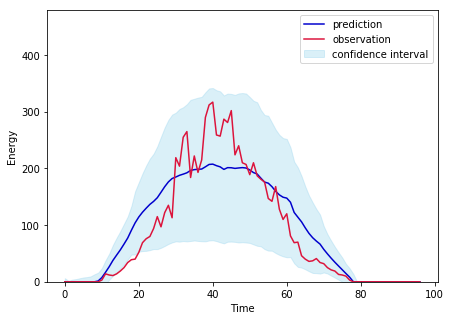

8


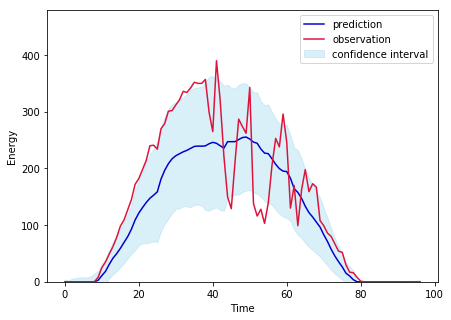

9


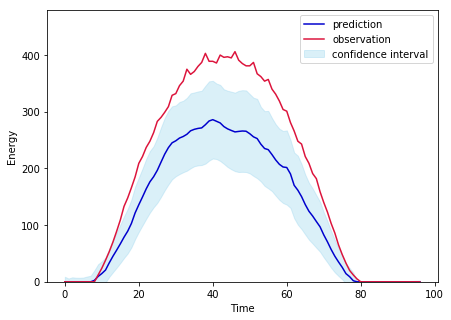

10


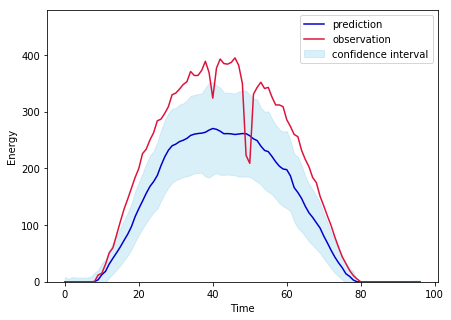

11


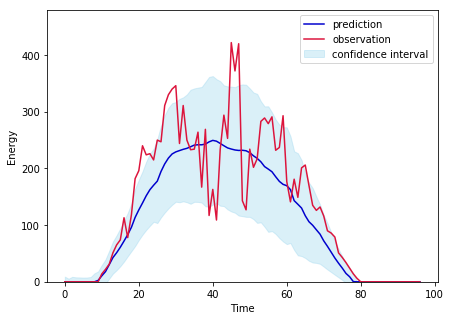

12


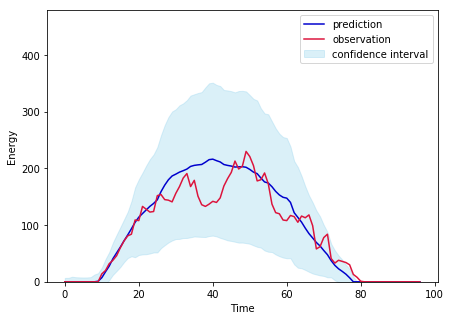

13


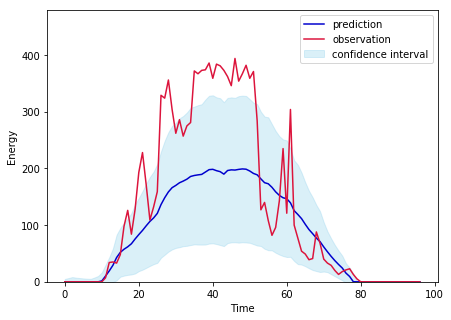

14


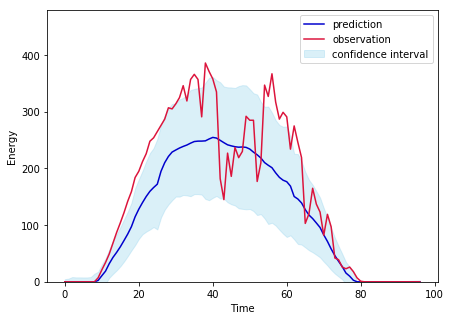

15


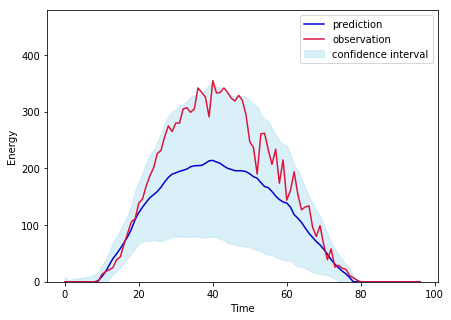

16


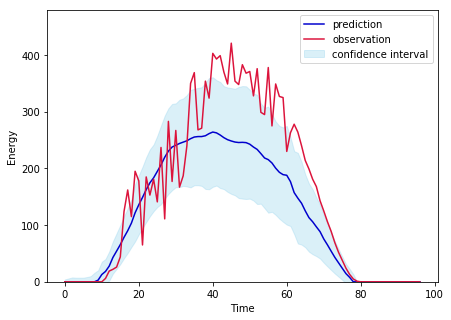

17


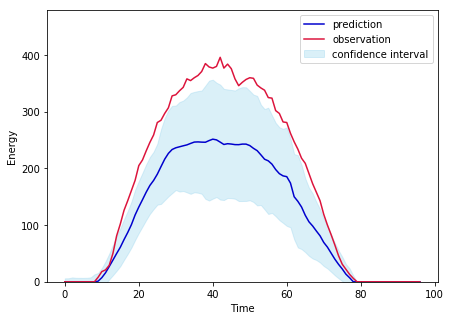

18


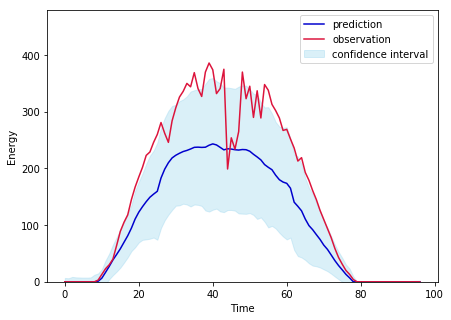

19


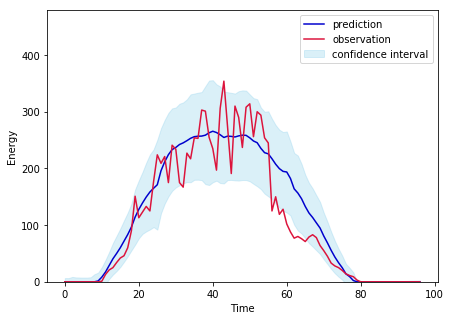

20


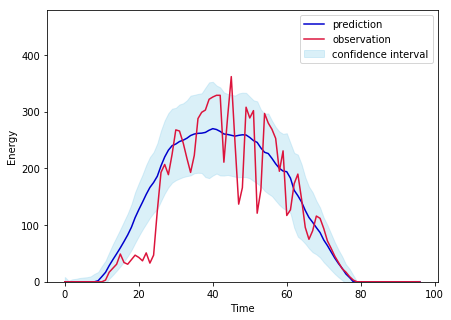

21


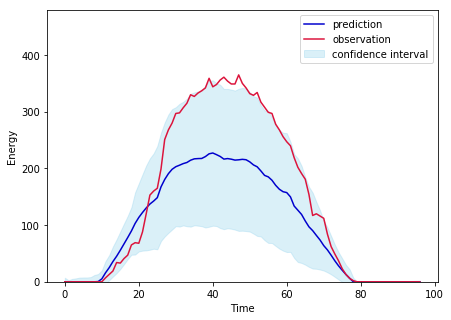

22


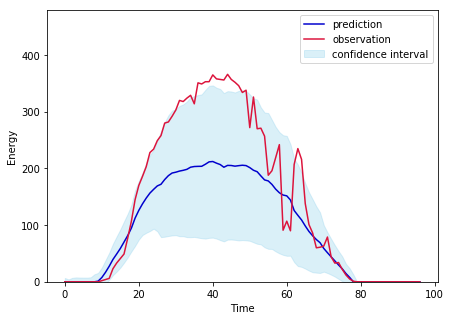

23


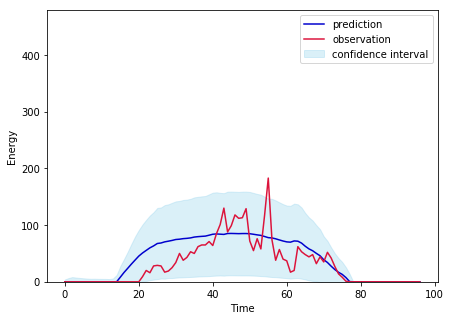

24


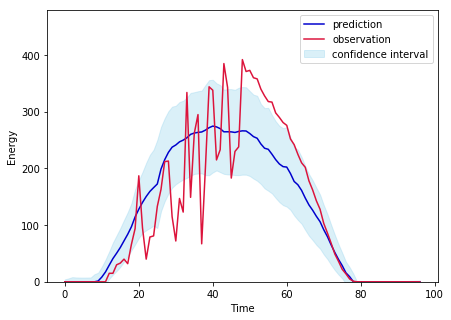

25


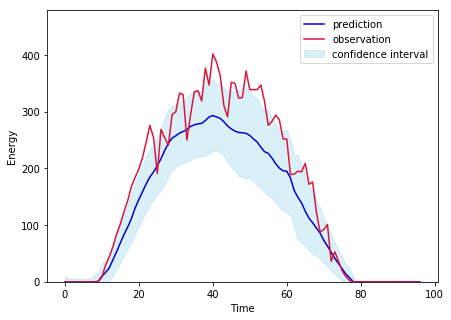

26


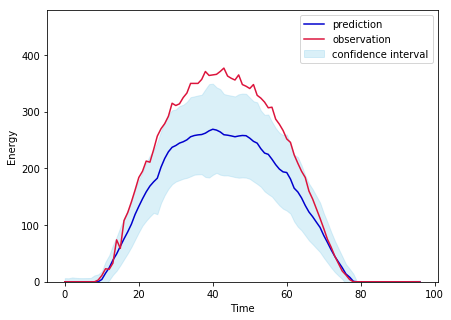

27


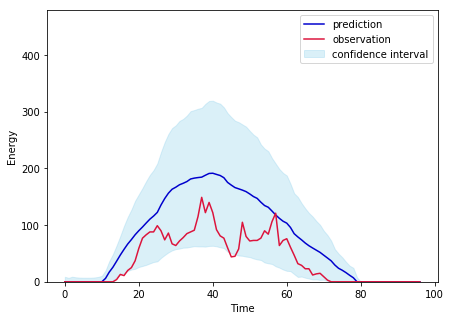

28


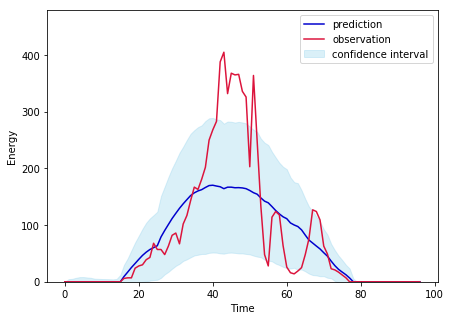

29


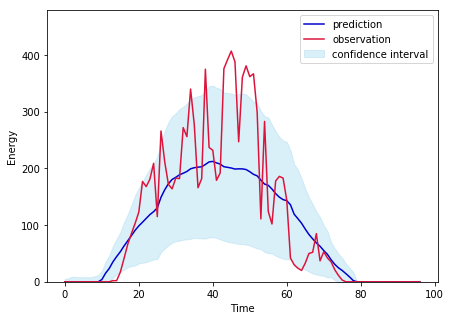

30


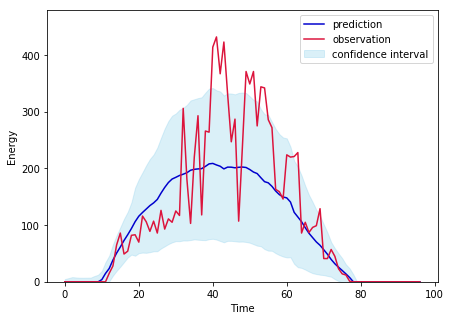

31


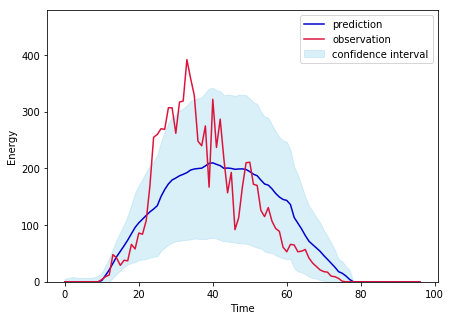

32


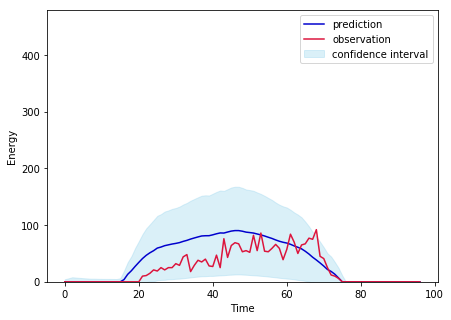

33


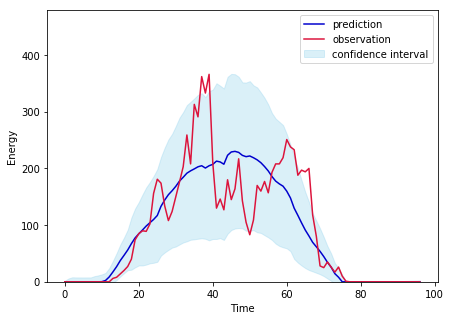

34


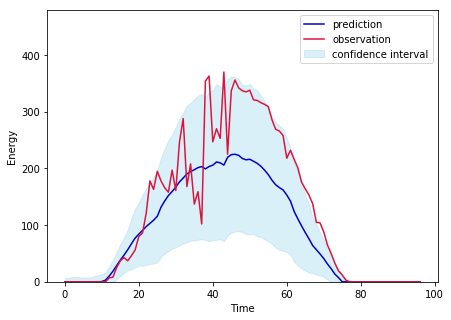

35


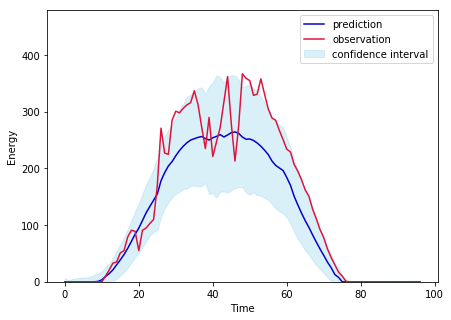

36


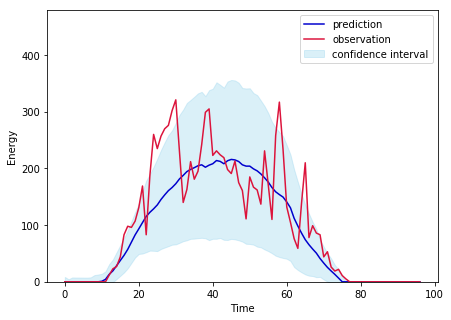

37


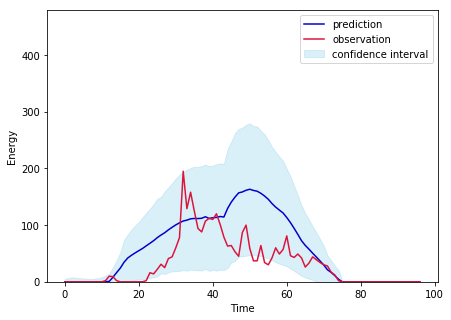

38


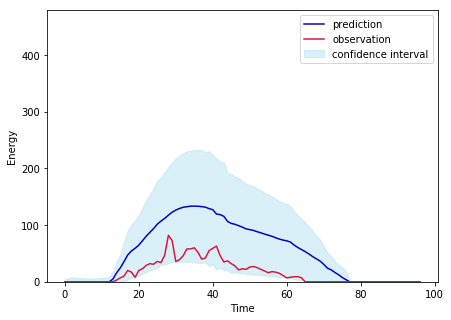

39


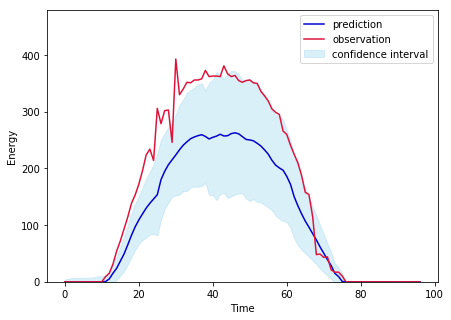

40


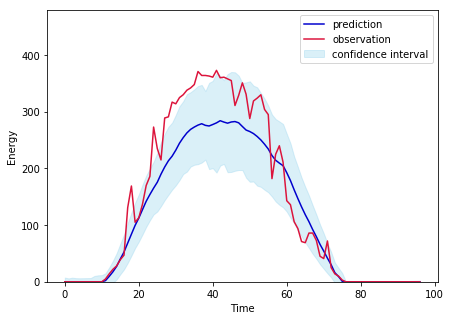

41


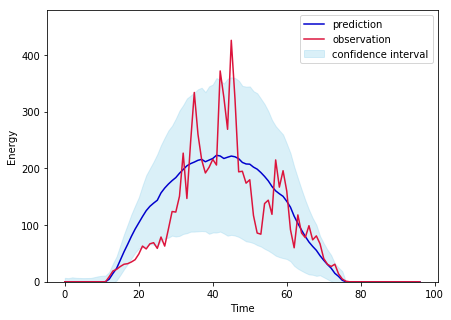

42


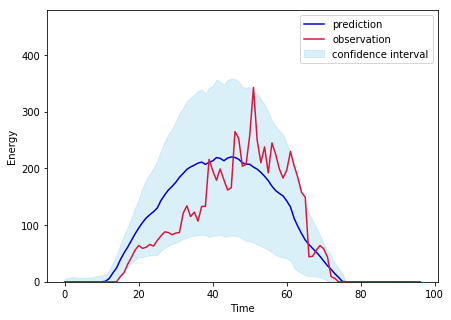

43


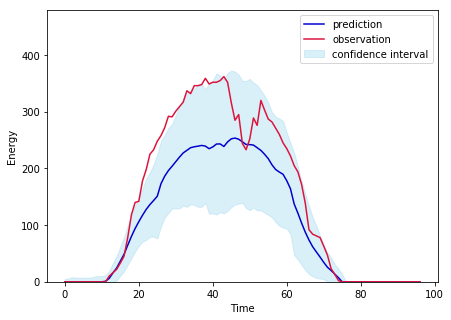

44


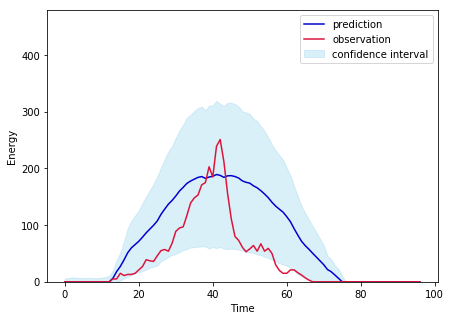

45


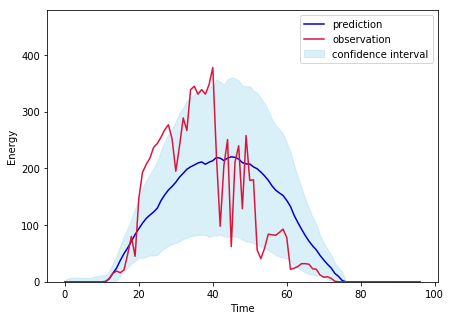

46


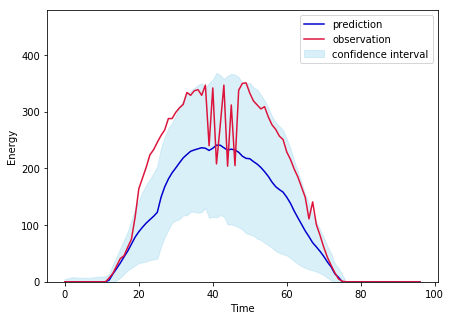

47


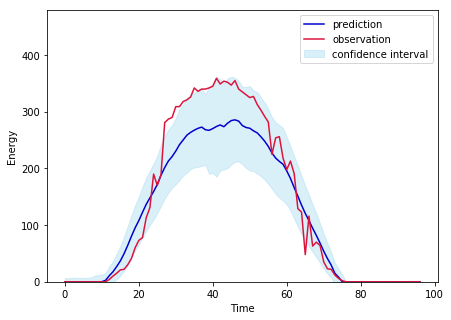

48


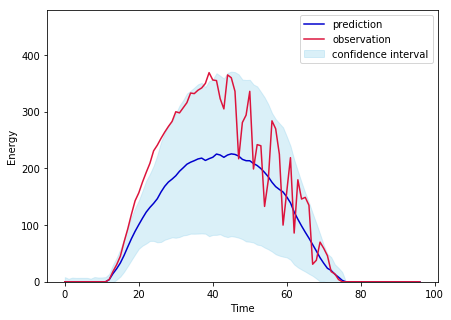

49


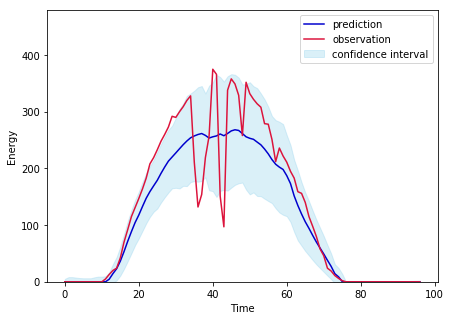

In [27]:
index = 0
for i in range(50):
    print(i)
    dec, std = evaluate(encoder1, decoder1, input_series[interval*index + interval*i], target_series[interval*index + interval*i], interval)
    plt.figure(figsize = (7,5))
    plt.plot(np.array(dec) * solar_max, label = 'prediction', color = 'mediumblue')
    plt.ylabel('Energy')
    plt.xlabel('Time')
    plt.fill_between(np.arange(interval), dec*solar_max+1.96*std*solar_max, dec*solar_max-1.96*std*solar_max, label='confidence interval', color = 'skyblue', alpha=0.3 )
    plt.plot(target_series[interval*index + interval*i, :, 0].cpu().numpy() * solar_max, label = 'observation', color = 'crimson')
    plt.ylim([0,solar_max])
    plt.legend()
    plt.show()

0


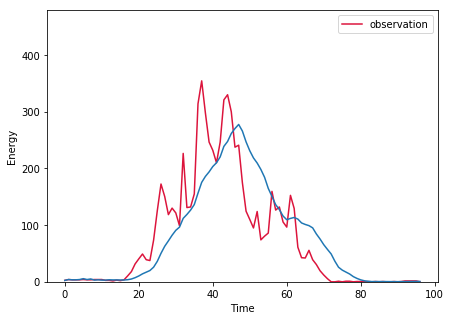

In [38]:
index = 350
for i in range(1):
    print(i)
    dec, std = evaluate(encoder1, decoder1, input_series[interval*index + interval*i], target_series[interval*index + interval*i], interval)
    plt.figure(figsize = (7,5))
#     plt.plot(np.array(dec) * solar_max, label = 'prediction', color = 'mediumblue')
    plt.ylabel('Energy')
    plt.xlabel('Time')
#     plt.fill_between(np.arange(interval), dec*solar_max+1.96*std*solar_max, dec*solar_max-1.96*std*solar_max, label='confidence interval', color = 'skyblue', alpha=0.3 )
    plt.plot(target_series[interval*index + interval*i, :, 0].cpu().numpy() * solar_max, label = 'observation', color = 'crimson')
    plt.plot(mv_a.cpu().numpy()*solar_max)
    plt.ylim([0,solar_max])
    plt.legend()
    plt.show()

In [37]:
mv_a = torch.zeros(interval)
for i in range(interval):
    if i<=11:
        mv_a[i] = target_series[interval*350 + interval*i, :, 0][i]
    else:
        mv_a[i] = torch.sum(target_series[interval*350, :, 0][i-11:i+1])/12